**Table of contents**

* [Introduction](#Introduction)
* [Preparation](#Preparation)
  * [Dependencies](#Dependencies)
  * [Load the datasets](#Load-the-datasets)
* [ARIMA](#ARIMA)
* [Time series data exploration](#Time-series-data-exploration)
  * [Distribution of sales](#Distribution-of-sales)
  * [How does sales vary across stores](#How-does-sales-vary-across-stores)
  * [How does sales vary across items](#How-does-sales-vary-across-items)
  * [Time-series visualization of the sales](#Time-series-visualization-of-the-sales)

# Introduction

Kernel for the [demand forecasting](https://www.kaggle.com/c/demand-forecasting-kernels-only) Kaggle competition.

Answer some of the questions posed:

* What's the best way to deal with seasonality?
* Should stores be modeled separately, or can you pool them together?
* Does deep learning work better than ARIMA?
* Can either beat xgboost?



  
  # Preparation
  
  ## Dependencies

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go


In [2]:
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import warnings
# import the_module_that_warns

warnings.filterwarnings("ignore")

# from fbprophet import Prophet # old incorrect import
from prophet import Prophet



## Load the datasets

In [3]:
# Input data files are available in the "../input/" directory.
# First let us load the datasets into different Dataframes
def load_data(datapath):
    data = pd.read_csv(datapath)
   # Dimensions
    print('Shape:', data.shape)
    # Set of features we have are: date, store, and item
    display(data.sample(10))
    return data
    
    
train_df = load_data('../input/demand-forecasting-kernels-only/train.csv')
test_df = load_data('../input/demand-forecasting-kernels-only/test.csv')
sample_df = load_data('../input/demand-forecasting-kernels-only/sample_submission.csv')

Shape: (913000, 4)


,date,store,item,sales
400957,2015-11-30,10,22,81
466131,2014-05-17,6,26,40
419164,2015-10-08,10,23,36
313444,2016-04-13,2,18,107
910990,2017-07-01,9,50,110
769909,2016-03-09,2,43,58
811488,2015-01-15,5,45,46
845642,2013-07-24,4,47,25
330835,2013-11-26,2,19,39
71511,2013-10-25,10,4,30


Shape: (45000, 4)


,id,date,store,item
37270,37270,2018-01-11,5,42
19152,19152,2018-03-14,3,22
28227,28227,2018-02-27,4,32
37965,37965,2018-03-17,2,43
6673,6673,2018-01-14,5,8
5976,5976,2018-02-06,7,7
9470,9470,2018-01-21,6,11
16994,16994,2018-03-16,9,19
16285,16285,2018-03-27,1,19
8107,8107,2018-01-08,1,10


Shape: (45000, 2)


,id,sales
15893,15893,52
873,873,52
25394,25394,52
2994,2994,52
8597,8597,52
30025,30025,52
23177,23177,52
31013,31013,52
17311,17311,52
32639,32639,52


# Time series data exploration

(This portion was [forked](https://www.kaggle.com/danofer/getting-started-with-time-series-features).)

The goal of this kernel is data exploration of a time-series sales data of store items.   
The tools `pandas`, `matplotlib`  and, `plotly`  are used for slicing & dicing the data and visualizations.


## Distribution of sales
Now let us understand how the sales varies across all the items in all the stores

In [4]:
# Sales distribution across the train data
def sales_dist(data):
    """
        Sales_dist used for Checing Sales Distribution.
        data :  contain data frame which contain sales data
    """
    sales_df = data.copy(deep=True)
    sales_df['sales_bins'] = pd.cut(sales_df.sales, [0, 50, 100, 150, 200, 250])
    print('Max sale:', sales_df.sales.max())
    print('Min sale:', sales_df.sales.min())
    print('Avg sale:', sales_df.sales.mean())
    print()
    return sales_df

sales_df = sales_dist(train_df)

# Total number of data points
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005

Sales bucket v/s Total percentage:


sales_bins
(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: count, dtype: float64

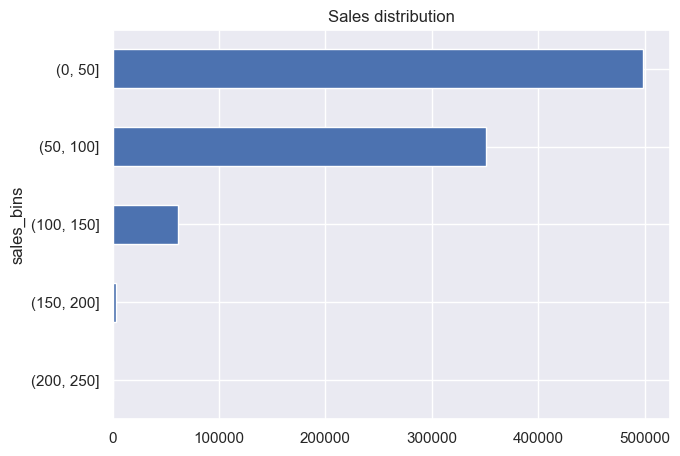

In [5]:
# Let us visualize the same
sales_count = pd.value_counts(sales_df.sales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh', title='Sales distribution', );
# sns.countplot(sales_count)

As we can see, almost 92% of sales are less than 100. Max, min and average sales are 231, 0 and 52.25 respectively.   
So any prediction model has to deal with the skewness in the data appropriately. 

## How does sales vary across stores
Let us get a overview of sales distribution in the whole data.

In [6]:
train_df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
store,,,,,,,,,,,,,,,,,,,,,
1,19.971522,53.148959,33.208105,19.956188,16.612815,53.060789,52.783680,69.472070,46.504929,66.354326,...,20.002738,33.105696,46.242607,26.594195,72.720701,52.845016,19.814348,46.546002,26.461665,59.342826
2,28.173604,75.316539,46.992333,28.234940,23.540526,74.945235,75.058598,99.090361,65.478094,94.097481,...,28.069551,47.368018,65.785323,37.785871,103.381161,75.219606,28.187842,66.028478,37.711939,84.622125
3,25.070099,66.804491,41.771084,25.116101,20.857612,67.007119,66.647864,87.517525,58.486857,83.387733,...,24.989047,41.797371,58.197700,33.386090,91.851041,66.748083,25.120482,58.700986,33.259584,74.958379
4,22.938664,61.715225,38.548193,23.086528,19.525192,61.270537,61.625411,80.819825,54.043812,77.047645,...,23.168127,38.539978,54.018620,30.952355,84.687295,61.420044,23.114458,53.765608,30.840635,68.921687
5,16.739321,44.488499,27.835706,16.776561,14.086528,44.564622,44.535597,58.565717,38.837349,55.509858,...,16.830778,27.730559,39.163198,22.415115,61.427163,44.734940,16.699343,39.281490,22.371851,50.319277
6,16.717963,44.533954,27.811062,16.754107,13.893209,44.503834,44.599124,58.385542,39.460022,55.565170,...,16.607338,27.893209,39.034502,22.322563,61.142935,44.539978,16.708653,39.052574,22.181271,50.516429
7,15.159365,40.717963,25.531216,15.358160,12.733844,40.703724,40.709748,53.723987,35.901972,51.156627,...,15.471522,25.435926,35.426068,20.446331,55.905805,40.828587,15.479189,35.624315,20.406353,45.823658
8,26.983571,71.656627,45.076123,26.948521,22.427711,71.958379,71.730559,94.461117,63.193319,89.818182,...,27.036145,45.144031,62.980285,36.194414,98.941402,72.004929,27.150055,62.737130,36.035049,80.972070
9,23.325849,61.792442,38.535049,23.150055,19.272180,61.412377,61.812158,81.287514,54.105696,77.105148,...,23.191128,38.643483,54.152793,30.968237,85.093647,62.010953,23.003286,53.976999,31.052574,69.308324


<Figure size 2000x1000 with 0 Axes>

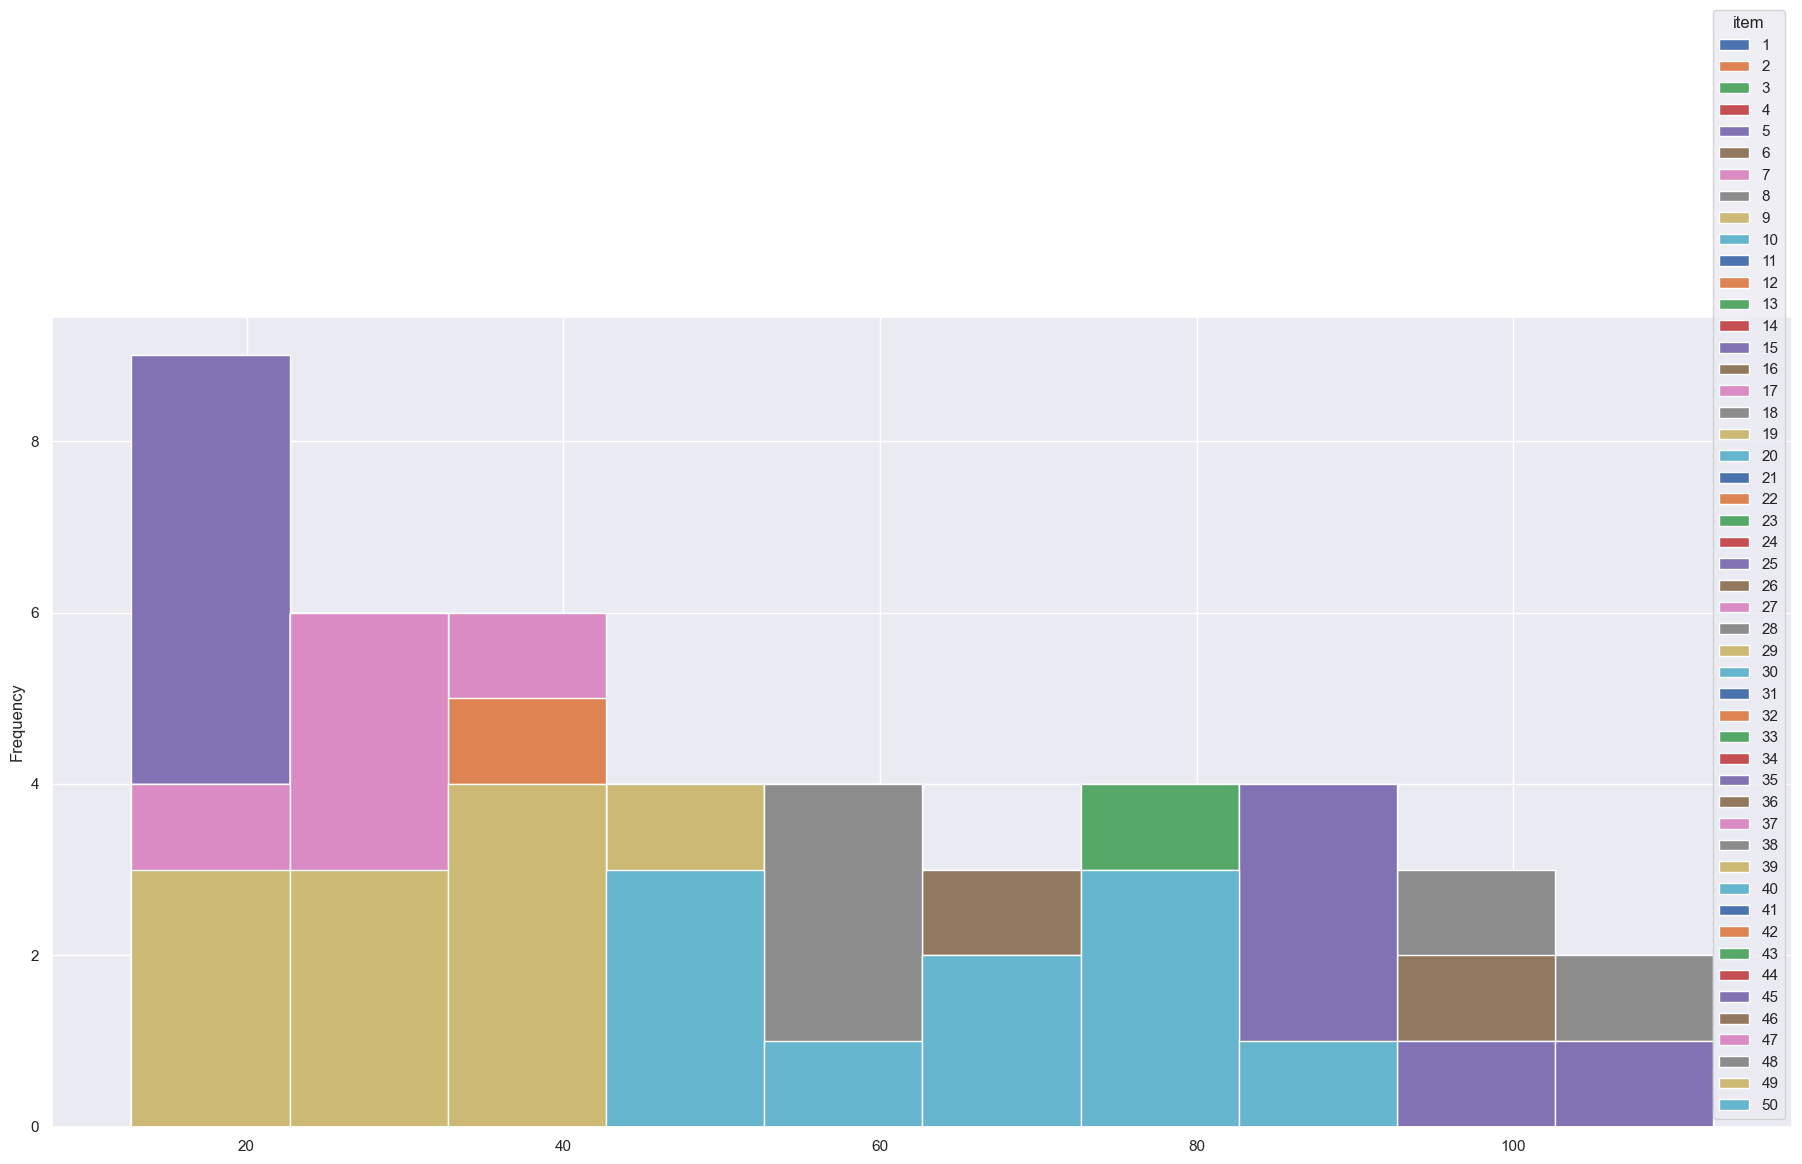

In [7]:
# Let us understand the sales data distribution across the stores
def sales_data_understanding(data):    
    store_df = data.copy()
    plt.figure(figsize=(20,10))
    # sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
    sales_pivoted_df = pd.pivot_table(store_df, index='store', values='sales', columns= 'item', aggfunc=np.mean)
    
    sales_pivoted_df.plot(kind="hist",figsize=(20,10))
    # Pivoted dataframe
    display(sales_pivoted_df)
    return (store_df,sales_pivoted_df)

store_df,sales_pivoted_df = sales_data_understanding(train_df)
# store_df,sales_pivoted_df = sales_data_understanding(train_df.sample(1000))

This pivoted dataframe has average sales per each store per each item.  
Let use this dataframe and produce some interesting visualizations!

In [8]:
# Let us calculate the average sales of all the items by each store
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)

In [9]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.avg_sale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.avg_sale.values,
        color = sales_across_store_df.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

From the visualization, it is clear that the stores with ID 2 and 8 have higher average sales than the remaining stores and is a clear indication that they are doing good money!

Whereas store with ID 7 has very poor performance in terms of average sales.

## How does sales vary across items

In [10]:
def sales_insight(sales_pivoted_df):
    # Let us calculate the average sales of each of the item across all the stores
    sales_across_item_df = sales_pivoted_df.copy()
    # Aggregate the sales per item and add it as a new row in the same dataframe
    sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
    # Note the 11th index row, which is the average sale of each of the item across all the stores
    #display(sales_across_item_df.loc[11:])
    avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['item', 'avg_sale'])
    # And finally, sort by avg sale
    avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
    # Display the top 10 rows
    display(avg_sales_per_item_across_stores_df.head())
    return (sales_across_item_df,avg_sales_per_item_across_stores_df)

sales_across_item_df,avg_sales_per_item_across_stores_df = sales_insight(sales_pivoted_df)

,item,avg_sale
14,15,88.030778
27,28,87.881325
12,13,84.316594
17,18,84.275794
24,25,80.686418


Great! Let us visualize these average sales per item!

In [11]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

Amazing! The sales is uniformly distributed across all the items.   
Top items with highest average sale are 15, 28, 13, 18 and with least average sales are 5, 1, 41 and so on.

## Time-series visualization of the sales
Let us see how sales of a given item in a given store varies in a span of 5 years.

In [12]:
def Time_visualization(data):
    store_item_df = data.copy()
    # First, let us filterout the required data
    store_id = 10   # Some store
    item_id = 40    # Some item
    print('Before filter:', store_item_df.shape)
    store_item_df = store_item_df[store_item_df.store == store_id]
    store_item_df = store_item_df[store_item_df.item == item_id]
    print('After filter:', store_item_df.shape)
    #display(store_item_df.head())

    # Let us plot this now
    store_item_ts_data = [go.Scatter(
        x=store_item_df.date,
        y=store_item_df.sales)]
    py.iplot(store_item_ts_data)
    return store_item_df

store_item_df = Time_visualization(train_df)

Before filter: (913000, 4)
After filter: (1826, 4)


Woww! Clearly there is a pattern here! Feel free to play around with different store and item IDs.   
Almost all the items and store combination has this pattern!

The sales go high in June, July and August months. The sales will be lowest in December, January and February months. That's something!!

Let us make it more interesting. What if we aggregate the sales on a montly basis and compare different items and stores.   
This should help us understand how different item sales behave at a high level.

In [13]:
def sales_monthly(data):
    multi_store_item_df = data.copy()
    # First, let us filterout the required data
    store_ids = [1, 1, 1, 1]   # Some stores
    item_ids = [10, 20, 30, 40]    # Some items
    print('Before filter:', multi_store_item_df.shape)
    multi_store_item_df = multi_store_item_df[multi_store_item_df.store.isin(store_ids)]
    multi_store_item_df = multi_store_item_df[multi_store_item_df.item.isin(item_ids)]
    print('After filter:', multi_store_item_df.shape)
    #display(multi_store_item_df)
    # TODO Monthly avg sales

    # Let us plot this now
    multi_store_item_ts_data = []
    for st,it in zip(store_ids, item_ids):
        flt = multi_store_item_df[multi_store_item_df.store == st]
        flt = flt[flt.item == it]
        multi_store_item_ts_data.append(go.Scatter(x=flt.date, y=flt.sales, name = "Store:" + str(st) + ",Item:" + str(it)))
    py.iplot(multi_store_item_ts_data)
    return (multi_store_item_df)

multi_store_item_df = sales_monthly(train_df)

Before filter: (913000, 4)
After filter: (7304, 4)


Interesting!!   
Though the pattern remains same across different stores and items combinations, the **actual sale value consitently varies with the same scale**. 

As we can see in the visualization, item 10 has consistently highest sales through out the span of 5 years!   
This is an interesting behaviour that can be seen across almost all the items. 



# ARIMA

ARIMA is Autoregressive Integrated Moving Average Model, which is a component of SARIMAX, i.e. Seasonal ARIMA with eXogenous regressors.

(sources: [1](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/), [2](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3), [3](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases))


http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases

# LIGHTGBM

In [14]:
def split_data(train_data,test_data):
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])

    train_data['month'] = train_data['date'].dt.month
    train_data['day'] = train_data['date'].dt.dayofweek
    train_data['year'] = train_data['date'].dt.year

    test_data['month'] = test_data['date'].dt.month
    test_data['day'] = test_data['date'].dt.dayofweek
    test_data['year'] = test_data['date'].dt.year

    col = [i for i in test_data.columns if i not in ['date','id']]
    y = 'sales'
    train_x, test_x, train_y, test_y = train_test_split(train_data[col],train_data[y], test_size=0.2, random_state=2018)
    return (train_x, test_x, train_y, test_y,col)

train_x, test_x, train_y, test_y, col = split_data(train_df,test_df)

In [15]:
train_df.shape, test_df.shape

((913000, 7), (45000, 7))

In [16]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape, col

((730400, 5),
 (730400,),
 (182600, 5),
 (182600,),
 ['store', 'item', 'month', 'day', 'year'])

In [17]:
train_x.shape[0] + test_x.shape[0]

913000

In [18]:
train_df.tail()

,date,store,item,sales,month,day,year
912995,2017-12-27,10,50,63,12,2,2017
912996,2017-12-28,10,50,59,12,3,2017
912997,2017-12-29,10,50,74,12,4,2017
912998,2017-12-30,10,50,62,12,5,2017
912999,2017-12-31,10,50,82,12,6,2017


In [19]:
test_df.head()

,id,date,store,item,month,day,year
0,0,2018-01-01,1,1,1,0,2018
1,1,2018-01-02,1,1,1,1,2018
2,2,2018-01-03,1,1,1,2,2018
3,3,2018-01-04,1,1,1,3,2018
4,4,2018-01-05,1,1,1,4,2018


In [20]:
# from bayes_opt import BayesianOptimization
# def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.02, output_process=False):
#     # prepare data
#     train_data = lgb.Dataset(data=X, label=y)
#     # parameters
#     def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
#         params = {'application':'regression_l1','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
#         params["num_leaves"] = int(round(num_leaves))
#         params['feature_fraction'] = max(min(feature_fraction, 1), 0)
#         params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
#         params['max_depth'] = int(round(max_depth))
#         params['lambda_l1'] = max(lambda_l1, 0)
#         params['lambda_l2'] = max(lambda_l2, 0)
#         params['min_split_gain'] = min_split_gain
#         params['min_child_weight'] = min_child_weight
#         cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
#         return max(cv_result['auc-mean'])
#     # range 
#     lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
#                                             'feature_fraction': (0.1, 0.9),
#                                             'bagging_fraction': (0.8, 1),
#                                             'max_depth': (5, 8.99),
#                                             'lambda_l1': (0, 5),
#                                             'lambda_l2': (0, 3),
#                                             'min_split_gain': (0.001, 0.1),
#                                             'min_child_weight': (5, 50)}, random_state=0)
#     # optimize
#     lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
#     # output optimization process
#     if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
#     # return best parameters
#     return lgbBO.res['max']['max_params']

# opt_params = bayes_parameter_opt_lgb(train_x, train_y, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=100, learning_rate=0.02)

In [21]:
# opt_params

In [22]:
%%time

def train_model(train_x,train_y,test_x,test_y,col):
    params = {
        'nthread': 10,
         'max_depth': 5,
#         'max_depth': 9,
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': 'mape', # this is abs(a-e)/max(1,a)
#         'num_leaves': 39,
        'num_leaves': 64,
        'learning_rate': 0.2,
       'feature_fraction': 0.9,
#         'feature_fraction': 0.8108472661400657,
#         'bagging_fraction': 0.9837558288375402,
       'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l1': 3.097758978478437,
        'lambda_l2': 2.9482537987198496,
#       'lambda_l1': 0.06,
#       'lambda_l2': 0.1,
        'verbose': 1,
        'min_child_weight': 6.996211413900573,
        'min_split_gain': 0.037310344962162616,
        }
    
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(test_x,test_y)
    # model = lgb.train(params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=50, verbose_eval=50)
    model = lgb.train(params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid], callbacks=[lgb.early_stopping(stopping_rounds=5)])
    y_test = model.predict(test_df[col])
    return y_test,model

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.77 μs


In [23]:
%%time
y_test, model = train_model(train_x,train_y,test_x,test_y,col)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 730400, number of used features: 5
[LightGBM] [Info] Start training from score 47.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [24]:
sample_df['sales'] = y_test
sample_df.to_csv('lgb.csv', index=False)
sample_df['sales'].head()

0    12.406018
1    13.398752
2    13.583040
3    13.498193
4    15.156966
Name: sales, dtype: float64

In [25]:
# def average(df1):
#     avg  = df1
#     df2 = pd.read_csv("../input/private/sub_val-0.132358565029612.csv")
#     avg['sales'] = (df1["sales"]*0.4 + df2["sales"]*0.6)
#     return avg

# avg = average(sample_df)
# avg.to_csv("Submission.csv", index=False)

In [26]:
# save model
model.save_model('lgb_model.txt')

In [27]:
model